# Hierarchical Navigable Small Worlds - HNSW
* [Hierarchical Navigable Small Worlds - HNSW (Zilliz)](https://zilliz.com/blog/hierarchical-navigable-small-worlds-HNSW)
* [Hierarcical Navigable Small Worls - HNSW (Pinecone)](https://www.pinecone.io/learn/series/faiss/hnsw/)
* [Vector Search](https://github.com/fzliu/vector-search/)
* [Reference code](https://github.com/fzliu/vector-search/blob/main/indexes/hnsw.py)
* [Reference notebook](https://github.com/fzliu/vector-search/blob/main/tutorials/2023-03-02_data_science_dojo_00_ann_algorithms.ipynb)

## Explanation

This is one type of [ANN](https://en.wikipedia.org/wiki/Nearest_neighbor_search) algorithm, where it's separated in N layers (the user decide that), for example in a 4 layers HNSW, the 4° layer will have less elements than the 3°, and the 3° will have less than the 2º, and so on. The algorithm behave that way because there's a function that increase the probability to insert the elements in the layer that is below, ensuring that in the first layer (4º layer in this example) will have at least one entry. You can modify the efc (efConstrution in [FAISS](https://github.com/facebookresearch/faiss)), to make the nearest neighbors of each layer has the number of efc nearest neighbors (if efc=20 each vertex will have 20 nearest neighbors for example), with that configuration parameter, you can have a trade-off control between runtime performance and accuracy (the greater the efc, the better the accuracy but probably slower).
The HNSW is inspired on the ["Probability Skip List" data structure](https://en.wikipedia.org/wiki/Skip_list), because both of then are divided in layers, where, with the top most layer, you can get "shortcuts" to the bottom layer where we wil find the nearest neighbor element fast, instead of search the entire array.
When you search for an element, you compare in the upper layer the nearest neighbors (that's limited by the ef parameter or efSearch in FAISS), after that, recursively/iteration you go to the bottom layer (if there's a link, because of the probability like skip list, you won't always have a link to the bottom layer) where's the element is next to, until the number of neighbors is found. To compare each of the element, you use some type of [priority queue](https://en.wikipedia.org/wiki/Priority_queue) with the closer neighbors at the top of the queue, the calculation of the order is defined by some metric distance, like Euclidean distance, Manhattan distance, etc. Another interesting thing, is that, the HNSW remember a lot the [Dijkistra Search Path](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) and more similar (the algorithm) to [A* Search Path](https://en.wikipedia.org/wiki/A*_search_algorithm) because in HNSW we can you heuristic (the distance) and we traverse a graph too.

Example of Probability Skip List:

<img alt="Probability Skip List Example" src="prob_skip_list.png" width="70%" />

HNSW Layers:

<img alt="Hierarchical Navigable Small Worlds Example" src="hnsw_layers.png" width="70%" />

HNSW number of elements per layer distribution:

<img alt="Hierarchical Navigable Small Worlds distribution per layer Example" src="hnsw_faiss_vs_python_distribution_layers.png" width="70%" />

<small>Source from <a href="https://zilliz.com/blog/hierarchical-navigable-small-worlds-HNSW">Zilliz</a></small><br/>
<small>Source from <a href="https://www.pinecone.io/learn/series/faiss/hnsw/">Pinecone</a></small>

## Code from tutorial using random data

In [25]:
import numpy as np
import pandas as pd

from typing import List
from bisect import insort
from collections import namedtuple
from heapq import heapify, heappop, heappush

Vertex = namedtuple('Vertex', 'vec neighbors layer')
Neighbor = namedtuple('Neighbor', 'dist idx')


class HNSW:

    def __init__(self, layers=5, multi_factor=0.62, efc=20):
        self._layers = layers
        self._multi_factor = multi_factor
        self._efc = efc
        self._index = [[] for _ in range(layers)]

    def create(self, dataset: np.ndarray):
        self._dataset = dataset
        for vec in dataset:
            self.insert(vec, self._efc)

    def search(self, query: np.ndarray, ef=1):
        index = self._index
        if not index[0]:
            return []

        best_vertex_idx = 0 # set the initial best vertex to the entry point
        for graph in index:
            best_dist, best_vertex_idx = self._search_layer(graph, best_vertex_idx, query, ef=1)[0]
            if graph[best_vertex_idx].layer:
                best_vertex_idx = graph[best_vertex_idx].layer
            else:
                return self._search_layer(graph, best_vertex_idx, query, ef=ef)

    def _search_layer(self, graph, entry_idx: int, query: np.ndarray, ef=1) -> List[Neighbor]: 
        best = Neighbor(dist=np.linalg.norm(graph[entry_idx].vec - query), idx=entry_idx)
        nearest_neighbors = [best]
        visited = set(best) # set of visited nodes
        candidates = [best] # candidate nodes to insert into nearest neighbors
        heapify(candidates)

        # find top-k nearest neighbors
        while candidates:
            candidate = heappop(candidates)
            if nearest_neighbors[-1].dist > candidate.dist:
                break

            # loop through all nearest neighbors to the candidate vector
            for neighbor_entry_idx in graph[candidate.idx].neighbors:
                distance = np.linalg.norm(graph[neighbor_entry_idx].vec - query)
                if Neighbor(dist=distance, idx=neighbor_entry_idx) in visited:
                    continue

                visited.add(Neighbor(dist=distance, idx=neighbor_entry_idx))

                # push only "better" vectors into candidate heap
                if distance < nearest_neighbors[-1].dist or len(nearest_neighbors) < ef:
                    heappush(candidates, Neighbor(dist=distance, idx=neighbor_entry_idx))
                    insort(nearest_neighbors, Neighbor(dist=distance, idx=neighbor_entry_idx))
                    if len(nearest_neighbors) > ef:
                        nearest_neighbors.pop()

        return nearest_neighbors

    def _get_insert_layer(self):
        layers = self._layers
        multi_factor = self._multi_factor
        # multi_factor is used to normalize the distribution
        which_layer = -int(np.log(np.random.random()) * multi_factor)
        return min(which_layer, layers-1)

    def insert(self, vec: np.ndarray, efc=10):
        # if the index is empty, insert the vector into all layers and return
        index = self._index
        layers = self._layers
        if not index[0]:
            i = None
            for graph in index[::-1]:
                graph.append(Vertex(vec=vec, neighbors=[], layer=i))
                i = 0
            return

        layer = self._get_insert_layer()

        start_vertex_idx = 0
        for n, graph in enumerate(index):
            # perform insertion for layers [layer, layers) only
            if n < layer:
                _, start_vertex_idx = self._search_layer(graph, start_vertex_idx, vec, ef=1)[0]
            else:
                insertion_layer = len(index[n+1]) if n < layers-1 else None
                node = Vertex(vec=vec, neighbors=[], layer=insertion_layer)
                nearest_neighbors = self._search_layer(graph, start_vertex_idx, vec, ef=efc)
                for nearest_neighbor in nearest_neighbors:
                    node.neighbors.append(nearest_neighbor.idx) # outbound connections to NNs
                    graph[nearest_neighbor.idx].neighbors.append(len(graph)) # inbound connections to node
                graph.append(node)
            # set the starting vertex to the nearest neighbor in the next layer
            start_vertex_idx = graph[start_vertex_idx].layer

    def plot_similar(self, df: pd.DataFrame, query_index: int, ef=5):
        """
        Helper function to take a dataframe index as input query 
        and display the k nearest neighbors
        """

        distances = []
        nearest_indices = []
        for (dist, idx) in self.search(self._dataset[query_index], ef=ef):
            distances.append(dist)
            nearest_indices.append(idx)

        # Plot input image
        with Image.open(df["img_path"][query_index]) as img:
            img = img.convert("RGB")
            plt.imshow(img)
        plt.title(f"Query Product: {query_index}")

        # Plot nearest neighbors images
        fig = plt.figure(figsize=(20, 4))
        plt.suptitle("Similar Products")
        for idx, neighbor in enumerate(nearest_indices):
            plt.subplot(1, len(nearest_indices), idx+1)
            with Image.open(df["img_path"][neighbor]) as img:
                img = img.convert("RGB")
                plt.imshow(img)
                plt.title(f"Distance: {distances[idx]:.3f}")
        plt.tight_layout()

In [26]:
import queue
import numpy as np

class FlatIndex:

    def __init__(self):
        self._index = None

    def create(self, dataset):
        """The index is the same as the dataset itself."""
        self._index = dataset

    def search(self, vector, nq=10):
        """Naive (flat) search."""
        nns = queue.PriorityQueue()  # should probably use heapq
        for (n, v) in enumerate(self._index):
            d = -np.linalg.norm(v - vector)
            if nns.qsize() == 0 or d > nns.queue[0][0]:
                nns.put((d, n))
                if nns.qsize() > nq:
                    nns.get()
        out = []
        for n in range(nq):
            if nns.empty():
                break
            out.insert(0, nns.get())
        return out

    @property
    def index(self):
        if self._index:
            return self._index
        raise ValueError("Call create() first")

In [27]:
dataset = np.random.normal(size=(1000, 128))

hnsw = HNSW()
hnsw.create(dataset)
%timeit hnsw.search(np.random.randn(128))

7.61 ms ± 547 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Compare result with flat index

In [28]:
value = np.random.randn(128)
hnsw.search(value, ef=5)

[Neighbor(dist=13.441443206348284, idx=477),
 Neighbor(dist=13.829142859968185, idx=899),
 Neighbor(dist=13.846891841499133, idx=31),
 Neighbor(dist=14.055527949614405, idx=11),
 Neighbor(dist=14.174200754517678, idx=46)]

In [29]:
flat = FlatIndex()
flat.create(dataset)
flat.search(value, nq=5)

[(-13.441443206348284, 477),
 (-13.483524482815954, 210),
 (-13.695116675731587, 623),
 (-13.829142859968185, 899),
 (-13.846891841499133, 31)]

## Code using embeddings with CLIP and FAISS

In [30]:
import os
import sys
import shutil
import faiss
import pandas as pd
import numpy as np 
import plotly.express as px

from PIL import Image
from random import randint
from tqdm import tqdm
from matplotlib import pyplot as plt

tqdm.pandas()

if os.path.exists("image_df.pkl"):
    image_df = pd.read_pickle("image_df.pkl")
else:
    print("RUN THE TUTORIAL 1_similarity_search.ipynb")

In [31]:
image_df.head()

,img_path,embedding,simclr_embeddings,clip_image_embedding
0,../data/cv/fashion/1000000151.jpg,"[0.0, 0.13571438, 0.07747779, 0.0, 0.06867723,...","[0.0, 0.0, 0.0, 0.016052447259426117, 0.067167...","[-0.08758709579706192, -0.3124939203262329, 0...."
1,../data/cv/fashion/1000000170.jpg,"[0.020778598, 0.09365222, 0.10665407, 0.051480...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.03924274817109108, -0.040139153599739075, ..."
2,../data/cv/fashion/1000001050.jpg,"[0.0, 0.017002566, 0.0101805935, 0.00038356014...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.07215095311403275, -0.07616670429706573, 0..."
3,../data/cv/fashion/1000001113.jpg,"[0.0, 0.032862574, 0.0, 0.0, 0.16102254, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.10626209527254105, 0.0,...","[0.12239596992731094, 0.23508524894714355, 0.2..."
4,../data/cv/fashion/1000001117.jpg,"[0.07896162, 0.0087613, 0.06798893, 0.0, 0.055...","[0.0, 0.0, 0.0, 0.0, 0.014906682074069977, 0.0...","[0.24037981033325195, 0.0034865587949752808, 0..."


In [32]:
embeddings = image_df["clip_image_embedding"]
embeddings = embeddings.to_numpy()
embeddings = np.array([np.array(embedding) for embedding in embeddings])
embeddings.shape

(6239, 512)

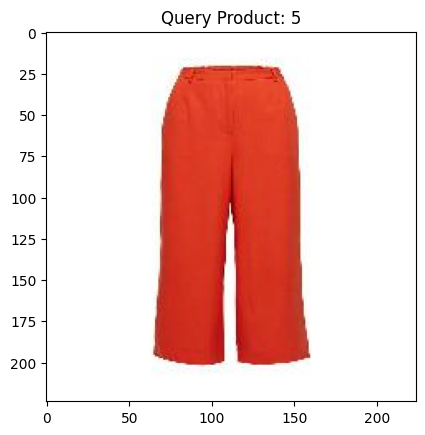

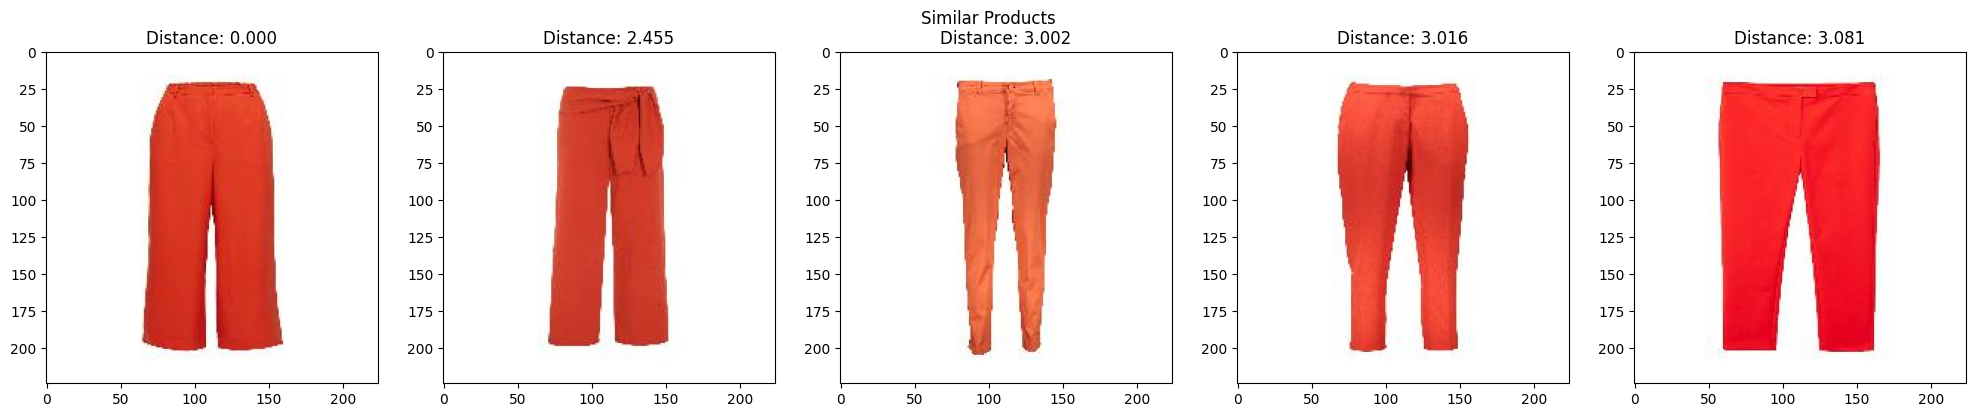

In [33]:
hnsw_embedding = HNSW()
hnsw_embedding.create(embeddings)
hnsw_embedding.plot_similar(df=image_df, query_index=5)

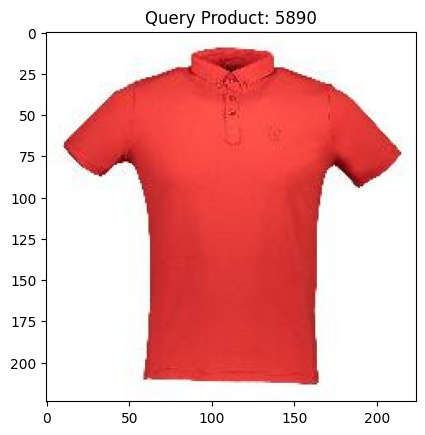

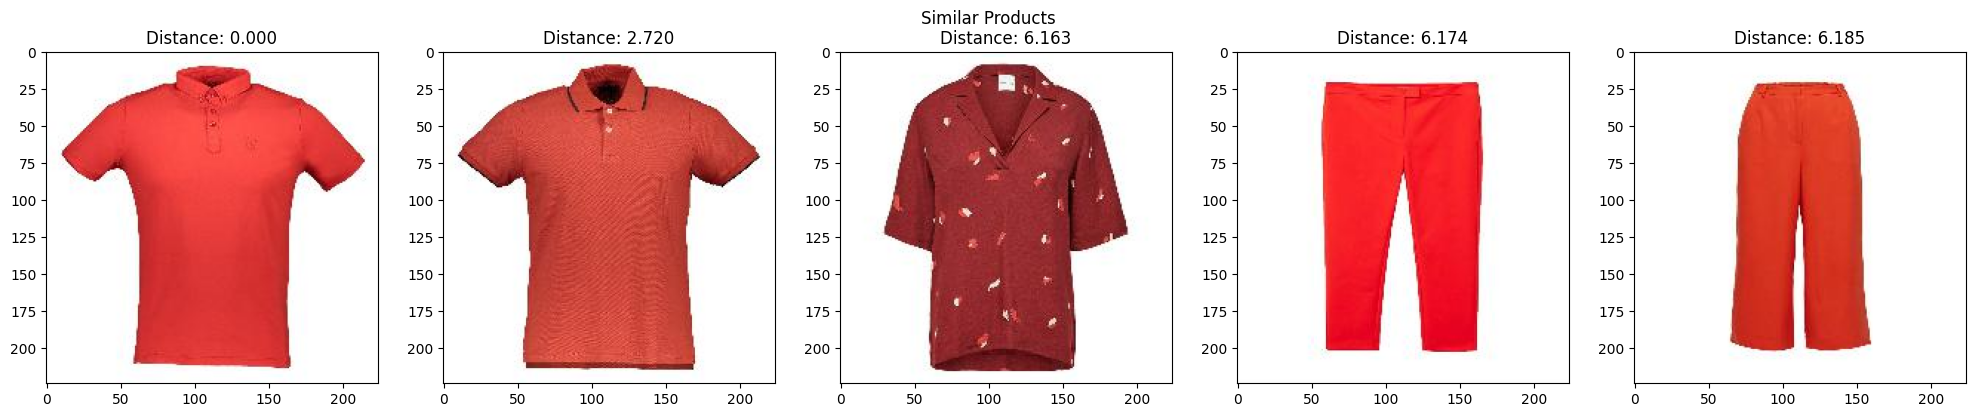

In [34]:
hnsw_embedding.plot_similar(df=image_df, query_index=5890)

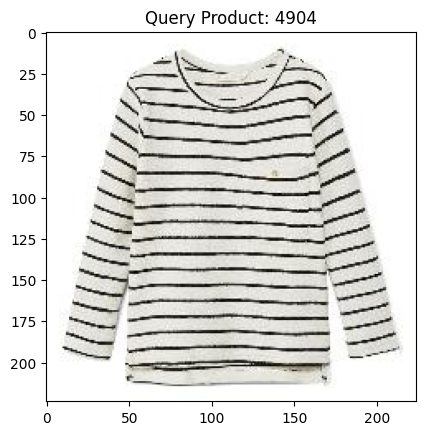

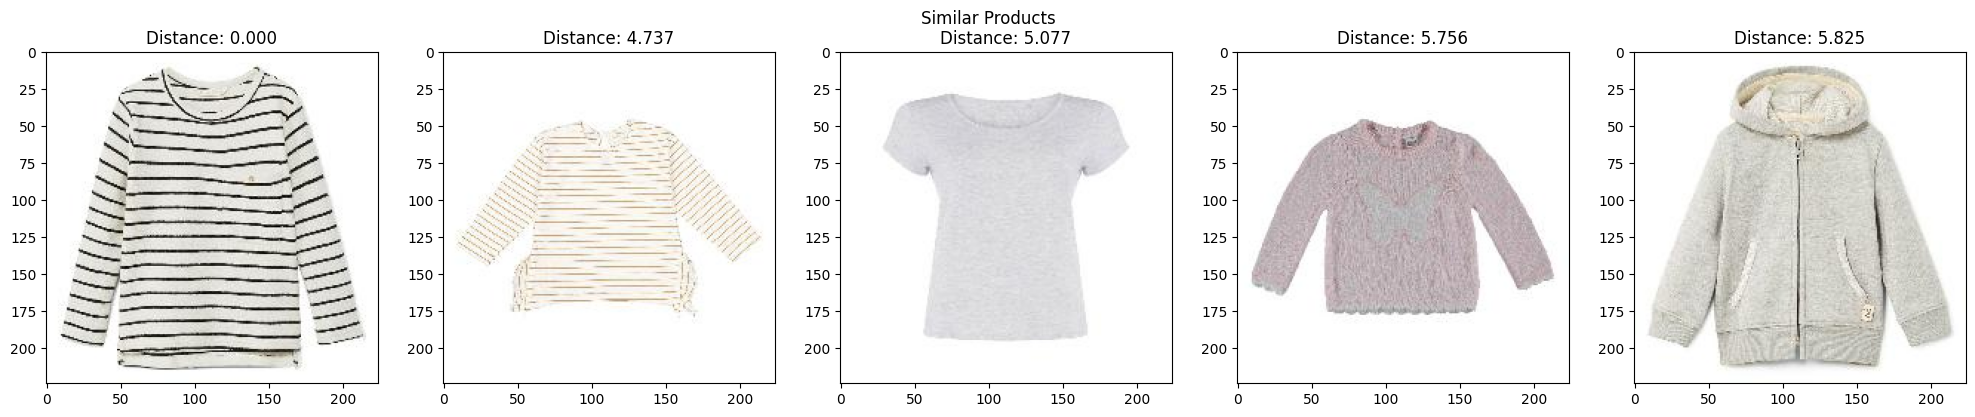

In [35]:
hnsw_embedding.plot_similar(df=image_df, query_index=randint(0, len(embeddings)))

In [36]:
dims = embeddings.shape[1]
number_links_per_vertex = 32
index = faiss.IndexHNSWFlat(dims, number_links_per_vertex)
print("max level:", index.hnsw.max_level)
levels = faiss.vector_to_array(index.hnsw.levels)
np.bincount(levels)

max level: -1


array([], dtype=int64)

In [37]:
index.add(embeddings)

In [38]:
levels = faiss.vector_to_array(index.hnsw.levels)
print("max level:", index.hnsw.max_level)
np.bincount(levels)

max level: 2


array([   0, 6065,  169,    5], dtype=int64)

In [39]:
def plot_similar(df: pd.DataFrame, query_index: int, k=5):
    """
    Helper function to take a dataframe index as input query 
    and display the k nearest neighbors
    """

    query = np.expand_dims(embeddings[query_index], axis=0)
    distances, nearest_indices = index.search(query, k=k)
    distances, nearest_indices = np.squeeze(distances), np.squeeze(nearest_indices)

    # Plot input image
    with Image.open(df["img_path"][query_index]) as img:
        img = img.convert("RGB")
        plt.imshow(img)
    plt.title(f"Query Product: {query_index}")

    # Plot nearest neighbors images
    fig = plt.figure(figsize=(20, 4))
    plt.suptitle("Similar Products")
    for idx, neighbor in enumerate(nearest_indices):
        plt.subplot(1, len(nearest_indices), idx+1)
        with Image.open(df["img_path"][neighbor]) as img:
            img = img.convert("RGB")
            plt.imshow(img)
            plt.title(f"Distance: {distances[idx]:.3f}")
    plt.tight_layout()

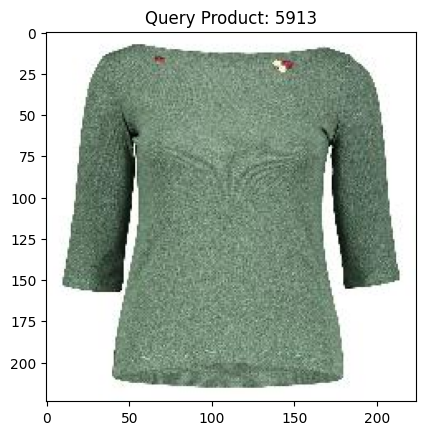

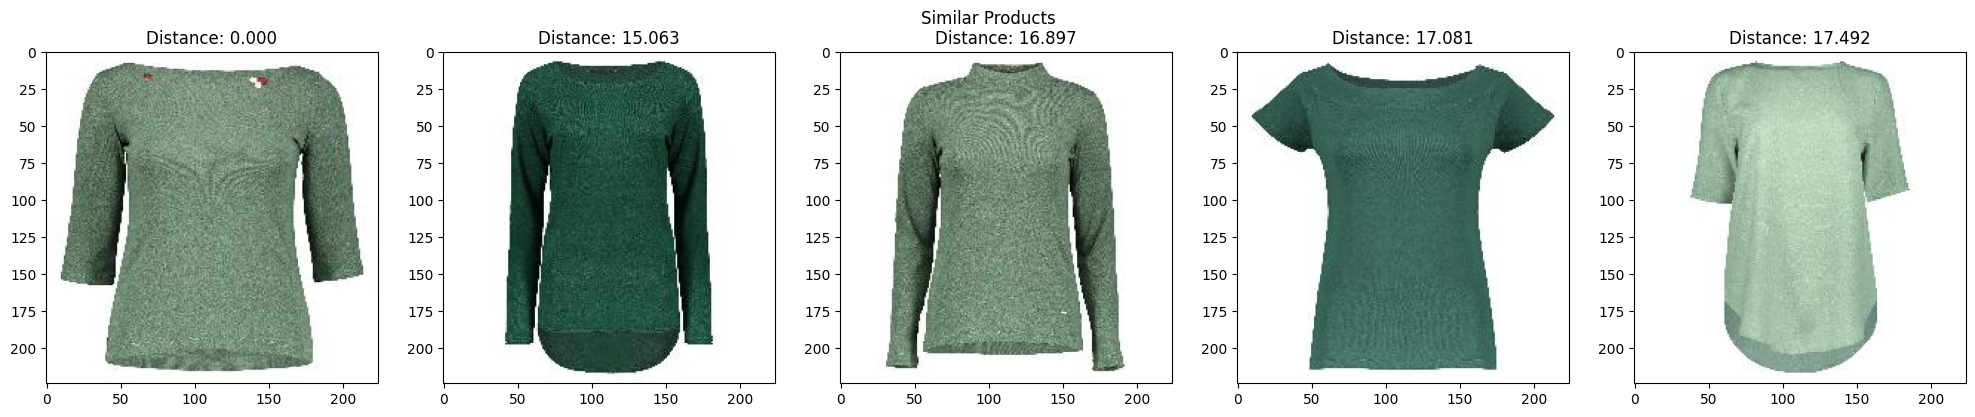

In [40]:
plot_similar(df=image_df, query_index=randint(0, len(embeddings)))

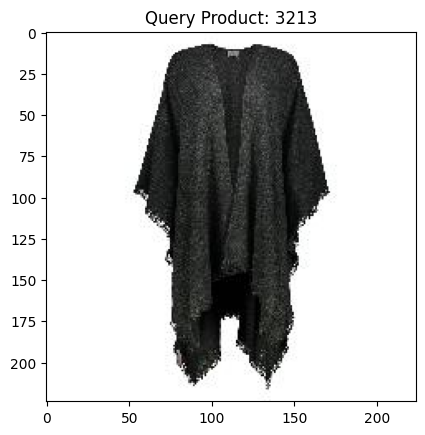

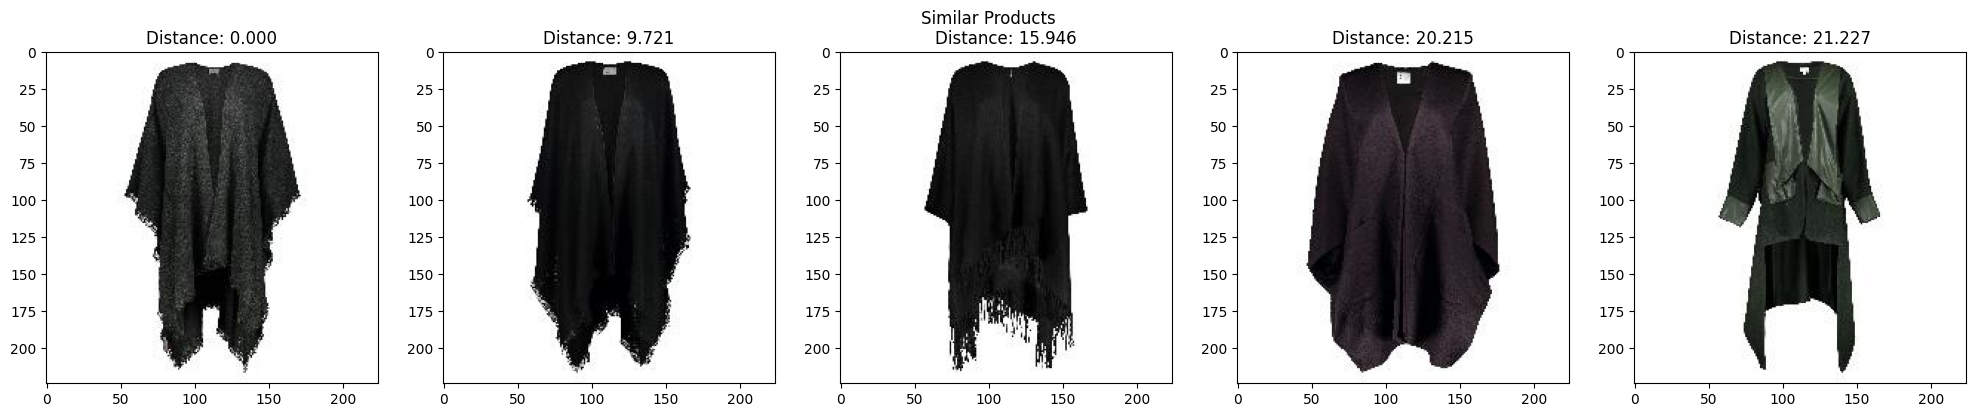

In [41]:
plot_similar(df=image_df, query_index=3213)